In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import warnings
warnings.filterwarnings(action='ignore')

import folium
KC_coord = (47.4081,-121.9949)
Seattle_coord = (47.6062,-122.3321)
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-notebook')
from yellowbrick.regressor import ResidualsPlot

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OrdinalEncoder, OneHotEncoder

In [2]:
df = pd.read_csv('./data/kc_house_data.csv', index_col=0, parse_dates=['date']) 
# specify index_col=0 to avoid creating an "Unnamed: 0" column.
# specify parse date to avoid object dtype for dates
df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,NO,NONE,Average,8 Good,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,NO,NONE,Average,8 Good,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,NO,NONE,Average,7 Average,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007


In [3]:
len(df)

21597

In [4]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [5]:
df.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.605368,0.053953,0.129599,-0.053402,0.306692,0.022036,0.585241,0.082845
bedrooms,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,0.479386,0.155670,0.018495,-0.154092,-0.009951,0.132054,0.393406,0.030690
bathrooms,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.686668,0.507173,0.051050,-0.204786,0.024280,0.224903,0.569884,0.088303
sqft_living,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.876448,0.318152,0.055660,-0.199802,0.052155,0.241214,0.756402,0.184342
sqft_lot,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.184139,0.052946,0.004513,-0.129586,-0.085514,0.230227,0.144763,0.718204
floors,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.523989,0.489193,0.003535,-0.059541,0.049239,0.125943,0.280102,-0.010722
sqft_above,0.605368,0.479386,0.686668,0.876448,0.184139,0.523989,1.000000,0.424037,0.022137,-0.261570,-0.001199,0.344842,0.731767,0.195077
yr_built,0.053953,0.155670,0.507173,0.318152,0.052946,0.489193,0.424037,1.000000,-0.225209,-0.347210,-0.148370,0.409993,0.326377,0.070777
yr_renovated,0.129599,0.018495,0.051050,0.055660,0.004513,0.003535,0.022137,-0.225209,1.000000,0.069846,0.032145,-0.072156,-0.000247,0.003852
zipcode,-0.053402,-0.154092,-0.204786,-0.199802,-0.129586,-0.059541,-0.261570,-0.347210,0.069846,1.000000,0.266742,-0.564259,-0.279299,-0.147294


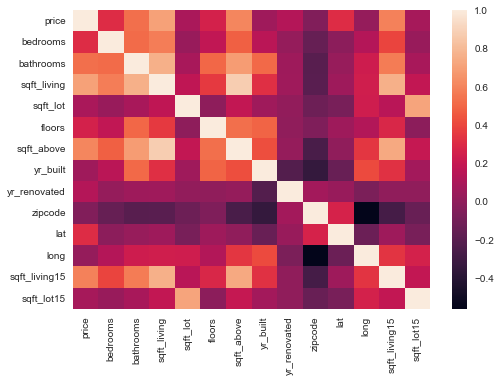

In [6]:
sns.heatmap(df.corr());

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7129300520 to 1523300157
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           21597 non-null  datetime64[ns]
 1   price          21597 non-null  float64       
 2   bedrooms       21597 non-null  int64         
 3   bathrooms      21597 non-null  float64       
 4   sqft_living    21597 non-null  int64         
 5   sqft_lot       21597 non-null  int64         
 6   floors         21597 non-null  float64       
 7   waterfront     19221 non-null  object        
 8   view           21534 non-null  object        
 9   condition      21597 non-null  object        
 10  grade          21597 non-null  object        
 11  sqft_above     21597 non-null  int64         
 12  sqft_basement  21597 non-null  object        
 13  yr_built       21597 non-null  int64         
 14  yr_renovated   17755 non-null  float64       
 15  zipco

In [8]:
df.isna().sum()

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [9]:
waterfront_count = df['waterfront'].value_counts()
waterfront_count

NO     19075
YES      146
Name: waterfront, dtype: int64

In [10]:
waterfront_proportions = df['waterfront'].value_counts()[1] / df['waterfront'].value_counts()[0]
waterfront_proportions

0.007653997378768021

In [11]:
watefront_null_proportion = df['waterfront'].isna().sum() * waterfront_proportions
watefront_null_proportion

18.185897771952817

In [12]:
waterfront_yes = df.loc[ df['waterfront'] == 'YES' ]

waterfront_avg_yes_price = np.mean( waterfront_yes['price'] )
waterfront_med_yes_price = np.median( waterfront_yes['price'] )

waterfront_null = df[df['waterfront'].isna()]
waterfront_null.loc[~waterfront_null.index.duplicated(), :]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1736800520,2015-04-03,662500.0,3,2.50,3560,9796,1.0,NaN,NONE,Average,8 Good,1860,1700.0,1965,0.0,98007,47.6007,-122.145,2210,8925
8091400200,2014-05-16,252700.0,2,1.50,1070,9643,1.0,NaN,NONE,Average,7 Average,1070,0.0,1985,NaN,98030,47.3533,-122.166,1220,8386
5547700270,2014-07-15,625000.0,4,2.50,2570,5520,2.0,NaN,NONE,Average,9 Better,2570,0.0,2000,NaN,98074,47.6145,-122.027,2470,5669
9822700295,2014-05-12,885000.0,4,2.50,2830,5000,2.0,NaN,NONE,Average,9 Better,2830,0.0,1995,0.0,98105,47.6597,-122.290,1950,5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5087900040,2014-10-17,350000.0,4,2.75,2500,5995,2.0,NaN,NONE,Average,8 Good,2500,0.0,2008,0.0,98042,47.3749,-122.107,2530,5988
8956200760,2014-10-13,541800.0,4,2.50,3118,7866,2.0,NaN,AVERAGE,Average,9 Better,3118,0.0,2014,0.0,98001,47.2931,-122.264,2673,6500
844000965,2014-06-26,224000.0,3,1.75,1500,11968,1.0,NaN,NONE,Average,6 Low Average,1500,0.0,2014,0.0,98010,47.3095,-122.002,1320,11303


In [13]:
waterfront_null_avg_filter = waterfront_null.loc[ waterfront_null['price'] >= waterfront_avg_yes_price ]
waterfront_null_med_filter = waterfront_null.loc[ waterfront_null['price'] >= waterfront_med_yes_price ]
waterfront_med = np.median(waterfront_null_med_filter['price'])


waterfront_null_avg_count = len(waterfront_null_avg_filter)  
waterfront_null_med_count = len(waterfront_null_med_filter) 

waterfront_convert = waterfront_null_med_count * waterfront_proportions

print(f"""mean: {np.round(waterfront_avg_yes_price, 2)}, count: {waterfront_null_avg_count} 

median: {waterfront_med_yes_price}, count: {waterfront_null_med_count}

waterfront_convert: {waterfront_convert}

median waterfront homes >= waterfront_med_yes_price: {waterfront_med}

{waterfront_null_med_filter}""")

mean: 1717214.73, count: 31 

median: 1510000.0, count: 53

waterfront_convert: 0.40566186107470514

median waterfront homes >= waterfront_med_yes_price: 1820000.0

                 date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
id                                                                             
46100204   2015-02-21  1510000.0         5       3.00         3300     33474   
3225079035 2014-06-18  1600000.0         6       5.00         6050    230652   
5486800070 2014-06-20  1950000.0         7       3.50         4640     15235   
8081500060 2014-10-01  1930000.0         4       3.25         4280     20296   
1118000465 2015-03-12  1810000.0         3       3.50         3780      8295   
7856400240 2015-02-11  1650000.0         4       3.00         3900      9750   
5452301785 2015-02-18  2300000.0         4       4.25         4070     13860   
251620110  2014-07-02  2290000.0         4       2.50         4080     18362   
1959701745 2014-11-07  1680000.0   

In [14]:
view_count = df['view'].value_counts()
view_count

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

In [15]:
condition_count = df['condition'].value_counts()
condition_count

Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

In [16]:
bedroom_count = df['bedrooms'].value_counts()
bedroom_count

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

# Data Preparation

In [17]:
#drop the 33 bedroom outlier 
df = df[df['bedrooms'] != 33]

In [18]:
df['bedrooms_bin']=pd.cut(df['bedrooms'], bins = [0,1,2,3,4,5,6,99], labels=['1 bed','2 bed','3 bed','4 bed','5 bed','6 bed','7+ bed'])
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,bedrooms_bin
id,,,,,,,,,,,,,,,,,,,,,
7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,...,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,3 bed
6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,...,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,3 bed
5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,...,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062,2 bed
2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,...,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,4 bed
1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,...,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,3 bed


In [19]:
#drop the 33 bedroom outlier 
df.drop(['date', 'yr_renovated', 'sqft_basement'], axis=1, inplace=True)
df.head()


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,bedrooms_bin
id,,,,,,,,,,,,,,,,,,
7129300520,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,1955,98178,47.5112,-122.257,1340,5650,3 bed
6414100192,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,1951,98125,47.7210,-122.319,1690,7639,3 bed
5631500400,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,1933,98028,47.7379,-122.233,2720,8062,2 bed
2487200875,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,1965,98136,47.5208,-122.393,1360,5000,4 bed
1954400510,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,1987,98074,47.6168,-122.045,1800,7503,3 bed


# Taking Out Outliers

### Price Outliers

In [20]:
# calculate 25, 75, iqr, whiskers for 'price'
price_q25, price_q75 = np.percentile(df['price'], [25, 75])
price_iqr = price_q75 - price_q25
price_min = price_q25 - (1.5 * price_iqr)
price_max = price_q75 + (1.5 * price_iqr)

print(f"""price_min: {price_min} 
price_max: {price_max}""")

price_min: -162500.0 
price_max: 1129500.0


In [21]:
# set df to include everything within the whiskers except the outliers
df = df[df['price'] >= price_min]
df = df[df['price'] <= price_max]

### Sqft Lot Outliers

In [22]:
# calculate 25, 75, iqr, whiskers for 'sqft_lot'
sqft_lot_q25, sqft_lot_q75 = np.percentile(df['sqft_lot'], [25, 75])
sqft_lot_iqr = sqft_lot_q75 - sqft_lot_q25
sqft_lot_min = sqft_lot_q25 - (1.5 * sqft_lot_iqr)
sqft_lot_max = sqft_lot_q75 + (1.5 * sqft_lot_iqr)


print(f"""sqft_lot_min: {sqft_lot_min} 
sqft_lot_max: {sqft_lot_max}""")

sqft_lot_min: -2975.125 
sqft_lot_max: 18291.875


In [23]:
# set df to include everything within the whiskers except the outliers
df = df[df['sqft_lot'] >= sqft_lot_min]
df = df[df['sqft_lot'] <= sqft_lot_max]

### Grade Outliers

In [24]:
# check value counts of grades
grade_count = print(df['grade'].value_counts())

7 Average        8371
8 Good           5297
6 Low Average    1872
9 Better         1866
10 Very Good      513
5 Fair            198
11 Excellent       75
4 Low              20
12 Luxury           1
3 Poor              1
Name: grade, dtype: int64


In [25]:
df = df[df['grade'] != '3 Poor']
df = df[df['grade'] != '12 Luxury']